## Daniel Howard, dah2183, QMSS 5074, Spring 2020 HW2
## Assignment #3: Write up a report using BBC text classification data
## Github Link : https://github.com/dhoward0497/QMSS5074_HW3
#### Please note, all the code and plots are presented below. The write up of the report and any findings found are typed up after the code and at the end of this documet.

In [55]:
## package imports

import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
import nltk
from string import punctuation
nltk.download('stopwords')
from nltk.corpus import stopwords 
import re
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv1D, Bidirectional, GRU, Embedding, MaxPooling1D, GlobalMaxPooling1D, LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
## data import
BBC_data = pd.read_csv("https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv")

BBC_data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [30]:
print("Number of texts total :", BBC_data["text"].count())
print("Number of unique text :", len(list(set(i for i in BBC_data["text"]))))
 ## some duplicate data wrt article names, need to remove duplicates

BBC_data = BBC_data.drop_duplicates().reset_index(drop=True)

Number of texts total : 2225
Number of unique text : 2126


## 1) Visualize the categories of your target variable and describe the dataset generally (the data includes news articles from the BBC news.)

In [31]:
print("Number of categories :", len(list(set(i for i in BBC_data["category"]))))
print("Category names       :", [i for i in BBC_data["category"].unique()])
print("Category counts      :")
print(BBC_data["category"].value_counts())

Number of categories : 5
Category names       : ['tech', 'business', 'sport', 'entertainment', 'politics']
Category counts      :
sport            504
business         503
politics         403
entertainment    369
tech             347
Name: category, dtype: int64


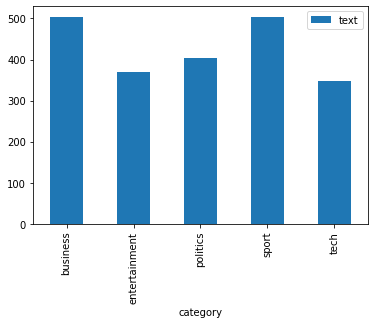

In [35]:
BBC_data.groupby("category").count().plot.bar()

plt.show()

In [32]:
total = 0
count = 0
for i in range(0, len(BBC_data["text"])):
  total+=int(len(BBC_data["text"][i].split()))
  count+=1
avg_len = total/count
print('The average text length is', avg_len)

The average text length is 390.45202257761053


The  five target categories are tech, business, sport, entertainment, and politics. There are 347, 503, 504, 369 and 403 articles in each of the respective topics. Clearly, there were many more articles on sport and business than tech, politics and entertainement. The texts have on average 390 words.


## 2) Preprocess your data such that each document in the data is represented as a sequence of equal length

In [0]:
stemmer = SnowballStemmer("english")

In [0]:
text_data = [i for i in BBC_data["text"]]

stop_words = set(stopwords.words('english') + list(punctuation))
regexp_tokenizer = nltk.RegexpTokenizer(r"\w+")

original_length = []
stemmed_length = []
stemmed_text = []
for row in text_data:
  new_row = row.split(" ")
  original_length.append(len(new_row))
  new_row = [x for x in new_row if len(x)>2]
  new_row = " ".join([str(elem) for elem in new_row if elem not in stop_words])
  new_row = regexp_tokenizer.tokenize(new_row)
  new_row = " ".join([str(elem) for elem in new_row if elem not in stop_words])
  new_row = re.sub(r'\d+', '',new_row)

  stemmed_length.append(len(new_row))
  stemmed_text.append(new_row)

BBC_data["text"] = stemmed_text

In [0]:
texts = BBC_data["text"]
categories = BBC_data["category"]

In [0]:
max_len = 250 # takes first 250 words only
max_words = 10000
train_len = 1500
val_len = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
tokened_text = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

text_data = pad_sequences(tokened_text, maxlen=max_len)

indices = np.arange(text_data.shape[0])
np.random.shuffle(indices)

ohe = OneHotEncoder()
y = ohe.fit_transform(np.asarray(categories).reshape(-1,1))

text_data = text_data[indices]
labels = y[indices]

X_train = text_data[:train_len]
y_train = labels[:train_len]

X_val = text_data[train_len: train_len + val_len]
y_val = labels[train_len: train_len + val_len]

X_test = text_data[train_len + val_len:]
y_test = labels[train_len + val_len:]

##  3) Use the data to fit separate models to each of the following architectures:

### A model with an embedding layer and dense layers (but w/ no layers meant for sequential data)


In [51]:
model1 = Sequential()

model1.add(Embedding(max_words, 256, input_length=max_len))

model1.add(Flatten())

model1.add(Dense(256, activation='sigmoid'))
model1.add(Dense(32, activation = "sigmoid"))
model1.add(Dense(5, activation='softmax'))

model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model1.summary()

epochs = 20

batch_size = 32

model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1500 samples, validate on 500 samples
Epoch 1/20
1500/1500 [==============================] - 13s 9ms/step - loss: 1.4103 - accuracy: 0.3980 - val_loss: 1.0755 - val_accuracy: 0.6780
Epoch 2/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.5483 - accuracy: 0.9687 - val_loss: 0.4350 - val_accuracy: 0.9480
Epoch 3/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2136 - accuracy: 1.0000 - val_loss: 0.2866 - val_accuracy: 0.9600
Epoch 4/20
1500/1500 [==============================] - 17s 12ms/step - loss: 0.1283 - accuracy: 1.0000 - val_loss: 0.2211 - val_accuracy: 0.9680
Epoch 5/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0897 - accuracy: 1.0000 - val_loss: 0.1858 - val_accuracy: 0.9720
Epoch 6/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0676 - accuracy: 1.0000 - val_loss: 0.1631 - val_accuracy: 0.9720
Epoch 7/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.053

### A model using an Embedding layer with Conv1d Layers





In [53]:
model2 = Sequential()

model2.add(Embedding(max_words, 256, input_length=max_len))

model2.add(Conv1D(64, kernel_size=2, strides=1))
model2.add(MaxPooling1D(2))

model2.add(Conv1D(256, kernel_size=4, strides=2))
model2.add(MaxPooling1D(2))

model2.add(Flatten())

model2.add(Dense(256, activation='relu'))
model2.add(Dense(5, activation='softmax'))

model2.compile(loss="categorical_crossentropy",optimizer = "adam", metrics = ["accuracy"])
model2.summary()

history = model2.fit(X_train, y_train,
                    epochs = 15, 
                    batch_size = 256,
                    validation_data = (X_val,y_val))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 256)          2560000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 249, 64)           32832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 124, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 61, 256)           65792     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 30, 256)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1500 samples, validate on 500 samples
Epoch 1/15
1500/1500 [==============================] - 4s 3ms/step - loss: 1.5270 - accuracy: 0.2967 - val_loss: 1.4762 - val_accuracy: 0.3540
Epoch 2/15
1500/1500 [==============================] - 4s 2ms/step - loss: 1.3466 - accuracy: 0.4400 - val_loss: 1.2818 - val_accuracy: 0.5140
Epoch 3/15
1500/1500 [==============================] - 4s 2ms/step - loss: 0.8671 - accuracy: 0.7600 - val_loss: 0.6520 - val_accuracy: 0.7720
Epoch 4/15
1500/1500 [==============================] - 4s 2ms/step - loss: 0.2366 - accuracy: 0.9473 - val_loss: 0.1872 - val_accuracy: 0.9460
Epoch 5/15
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0258 - accuracy: 0.9933 - val_loss: 0.1342 - val_accuracy: 0.9660
Epoch 6/15
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.1593 - val_accuracy: 0.9600
Epoch 7/15
1500/1500 [==============================] - 4s 2ms/step - loss: 7.8363e-04 - 

### A model using an Embedding layer with one sequential layer (LSTM or GRU)


In [56]:
model3 = Sequential()

model3.add(Embedding(max_words,256,input_length=max_len))

model3.add(GRU(256))
model3.add(Dense(256, activation='sigmoid'))
model3.add(Dense(5, activation='softmax'))

model3.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

batch_size = 256

model3.summary()

history = model3.fit(X_train, y_train,
                    epochs = 15, 
                    batch_size = 256,
                    validation_data=(X_val, y_val))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 256)          2560000   
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 1285      
Total params: 3,021,061
Trainable params: 3,021,061
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1500 samples, validate on 500 samples
Epoch 1/15
1500/1500 [==============================] - 28s 19ms/step - loss: 1.9726 - accuracy: 0.2307 - val_loss: 1.6668 - val_accuracy: 0.2620
Epoch 2/15
1500/1500 [==============================] - 27s 18ms/step - loss: 1.6312 - accuracy: 0.2360 - val_loss: 1.6282 - val_accuracy: 0.2200
Epoch 3/15
1500/1500 [==============================] - 27s 18ms/step - loss: 1.5597 - accuracy: 0.2447 - val_loss: 1.5843 - val_accuracy: 0.2240
Epoch 4/15
1500/1500 [==============================] - 27s 18ms/step - loss: 1.4129 - accuracy: 0.4273 - val_loss: 1.3062 - val_accuracy: 0.4520
Epoch 5/15
1500/1500 [==============================] - 27s 18ms/step - loss: 1.0797 - accuracy: 0.6393 - val_loss: 1.0935 - val_accuracy: 0.5420
Epoch 6/15
1500/1500 [==============================] - 28s 18ms/step - loss: 0.8667 - accuracy: 0.7160 - val_loss: 1.0830 - val_accuracy: 0.6060
Epoch 7/15
1500/1500 [==============================] - 27s 18ms/step - loss:

### A model using an Embedding layer with stacked sequential layers (LSTM or GRU)


In [59]:
model4 = Sequential()

model4.add(Embedding(max_words, 256, input_length=max_len))

model4.add(GRU(256, return_sequences=True))
model4.add(GRU(256))

model4.add(Dense(256, activation='relu'))
model4.add(Dense(5, activation='softmax'))

model4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

model4.summary()

history = model4.fit(X_train, y_train,
                    epochs = 10, 
                    batch_size = 256,
                    validation_data = (X_val, y_val))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 250, 256)          2560000   
_________________________________________________________________
gru_6 (GRU)                  (None, 250, 256)          393984    
_________________________________________________________________
gru_7 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 1285      
Total params: 3,415,045
Trainable params: 3,415,045
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1500 samples, validate on 500 samples
Epoch 1/10
1500/1500 [==============================] - 60s 40ms/step - loss: 1.6011 - accuracy: 0.2567 - val_loss: 1.5806 - val_accuracy: 0.3500
Epoch 2/10
1500/1500 [==============================] - 55s 36ms/step - loss: 1.5086 - accuracy: 0.3873 - val_loss: 1.4078 - val_accuracy: 0.4360
Epoch 3/10
1500/1500 [==============================] - 55s 36ms/step - loss: 0.9842 - accuracy: 0.5767 - val_loss: 0.8332 - val_accuracy: 0.7060
Epoch 4/10
1500/1500 [==============================] - 55s 37ms/step - loss: 0.3806 - accuracy: 0.8833 - val_loss: 0.7098 - val_accuracy: 0.7620
Epoch 5/10
1500/1500 [==============================] - 54s 36ms/step - loss: 0.1178 - accuracy: 0.9660 - val_loss: 0.7628 - val_accuracy: 0.7980
Epoch 6/10
1500/1500 [==============================] - 55s 36ms/step - loss: 0.0441 - accuracy: 0.9907 - val_loss: 0.9514 - val_accuracy: 0.7740
Epoch 7/10
1500/1500 [==============================] - 55s 36ms/step - loss:

### A model using an Embedding layer with bidirectional sequential layers


In [63]:
model5 = Sequential()

model5.add(Embedding(max_words, output_dim=32, input_length=max_len))

model5.add(Bidirectional(GRU(256)))

model5.add(Dense(256, activation='relu'))
model5.add(Dense(5, activation='softmax'))

model5.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])


model5.summary()


history = model5.fit(X_train, y_train,
                    epochs = 15, 
                    batch_size = 256,
                    validation_data = (X_val, y_val))

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 250, 32)           320000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               443904    
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 1285      
Total params: 896,517
Trainable params: 896,517
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1500 samples, validate on 500 samples
Epoch 1/15
1500/1500 [==============================] - 44s 29ms/step - loss: 0.4991 - accuracy: 0.8000 - val_loss: 0.4956 - val_accuracy: 0.8000
Epoch 2/15
1500/1500 [==============================] - 42s 28ms/step - loss: 0.4933 - accuracy: 0.8000 - val_loss: 0.4885 - val_accuracy: 0.8000
Epoch 3/15
1500/1500 [==============================] - 43s 28ms/step - loss: 0.4852 - accuracy: 0.8000 - val_loss: 0.4796 - val_accuracy: 0.8000
Epoch 4/15
1500/1500 [==============================] - 43s 28ms/step - loss: 0.4713 - accuracy: 0.8000 - val_loss: 0.4605 - val_accuracy: 0.8000
Epoch 5/15
1500/1500 [==============================] - 42s 28ms/step - loss: 0.5239 - accuracy: 0.7945 - val_loss: 0.4565 - val_accuracy: 0.8000
Epoch 6/15
1500/1500 [==============================] - 43s 28ms/step - loss: 0.4280 - accuracy: 0.8012 - val_loss: 0.4552 - val_accuracy: 0.8032
Epoch 7/15
1500/1500 [==============================] - 43s 28ms/step - loss:

### Now retrain your best model from C, D, and E using dropout (you may need to increase epochs!).

In [65]:
model6 = Sequential()

model6.add(Embedding(max_words,256,input_length=max_len))

model6.add(GRU(256,dropout=.5))
model6.add(Dense(256, activation='sigmoid'))
model6.add(Dense(5, activation='softmax'))

model6.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

batch_size = 256

model6.summary()

history = model6.fit(X_train, y_train,
                    epochs = 30, 
                    batch_size = 256,
                    validation_data=(X_val, y_val))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 250, 256)          2560000   
_________________________________________________________________
gru_12 (GRU)                 (None, 256)               393984    
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 1285      
Total params: 3,021,061
Trainable params: 3,021,061
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1500 samples, validate on 500 samples
Epoch 1/30
1500/1500 [==============================] - 28s 19ms/step - loss: 1.7335 - accuracy: 0.2053 - val_loss: 1.6449 - val_accuracy: 0.2200
Epoch 2/30
1500/1500 [==============================] - 28s 18ms/step - loss: 1.6028 - accuracy: 0.2460 - val_loss: 1.5922 - val_accuracy: 0.2620
Epoch 3/30
1500/1500 [==============================] - 27s 18ms/step - loss: 1.5812 - accuracy: 0.2307 - val_loss: 1.5556 - val_accuracy: 0.2620
Epoch 4/30
1500/1500 [==============================] - 27s 18ms/step - loss: 1.4637 - accuracy: 0.4293 - val_loss: 1.3792 - val_accuracy: 0.6020
Epoch 5/30
1500/1500 [==============================] - 27s 18ms/step - loss: 1.5250 - accuracy: 0.5640 - val_loss: 1.3535 - val_accuracy: 0.4020
Epoch 6/30
1500/1500 [==============================] - 28s 18ms/step - loss: 1.1274 - accuracy: 0.6380 - val_loss: 1.3106 - val_accuracy: 0.4780
Epoch 7/30
1500/1500 [==============================] - 27s 18ms/step - loss:

## Discuss which model(s) performed best and speculate about how you might try to further improve the predictive power of your model (e.g. Glove embeddings? More layers? Combining Conv1D with LSTM layers? More LSTM hidden nodes?)


The best model was the model with Conv1D layers, which had a val_accuracy score of 0.9660. This is surprising as it is expected that the model with bidirectional layers would be the one to best perform, as it can process and "read" text data in both directions. This helps it understand the text and the meaning of the words within the context of the text.

Using glove embeddings and more layers could have improved the model. It would also be interesting to see if adding more Conv1d layers or combining with bidrectional GRU layers would improve the model score. However, at 0.966, it is already very accurate.